<a href="https://colab.research.google.com/github/aulphin/GuISE-XAI/blob/main/morning_medi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect to the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/New-Project

/content/drive/.shortcut-targets-by-id/1ho2ZxmQ9ohP8W6JjYS1G-B3VSrKWEEgi/New-Project


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

Recreate the model architecture

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class TumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifier, self).__init__()
        # Load a pre-trained ResNet-50 model
        self.resnet50 = models.resnet50(pretrained=True)

        # Freeze the feature layers (optional, depends on your requirement)
        for param in self.resnet50.parameters():
            param.requires_grad = True

        # Replace the classifier of ResNet-50
        # ResNet-50's last layer (fc) output features is 2048
        self.resnet50.fc = nn.Sequential(
            #nn.Linear(2048, 512),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.2),
            nn.Linear(2048, num_classes)  # Output layer for 4 classes
        )

    def forward(self, x):
        return self.resnet50(x)

In [ ]:
# Create an instance of the model for 4 classes
num_classes = 4
model = TumorClassifier(num_classes=num_classes)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model = model

Load the saved model

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/New-Project/best_model.pth'))
model.eval()  # Set the model to evaluation mode
A_model = model

Prepare your input data for Prediction

In [ ]:
from PIL import Image

def process_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),

        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

In [ ]:
import torch

def predict(image_path, model, device):
    image = process_image(image_path)
    image = image.to(device)

    with torch.no_grad():  # No need to track gradients
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        prediction = torch.argmax(probabilities, dim=1)
        return prediction, probabilities

# Example usage
image_path = '/content/drive/MyDrive/Colab Notebooks/New-Project/data/meningioma/Te-meTr_0000.jpg'# Replace with your image path
prediction, probabilities = predict(image_path,A_model, device)
print(f'Predicted Class: {prediction.item()}, Probabilities: {probabilities}')


Predicted Class: 1, Probabilities: tensor([[1.5883e-07, 9.4943e-01, 1.4757e-03, 4.9094e-02]], device='cuda:0')


Rise

In [ ]:
import torch
import numpy as np
from torchvision import transforms
from PIL import Image

class Model():
    def __init__(self, pytorch_model):

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = pytorch_model
        self.model.to(self.device)

        self.model.eval()  # Set the model to evaluation mode
        self.input_size = (224, 224)
        self.transform = transforms.Compose([
           transforms.Resize((224, 224)),
           transforms.ToTensor(),])

    def run_on_batch(self, x):
        processed_images = []
        for img in x:
            # Convert the image to uint8 if it's not already
            if img.dtype != np.uint8:
                img = (img * 255).astype(np.uint8)

            # Convert numpy array to PIL Image
            img_pil = Image.fromarray(img)
            img_transformed = self.transform(img_pil)
            processed_images.append(img_transformed)

        # Stack all processed images into a single tensor and move to the same device as the model
        x_tensor = torch.stack(processed_images).to(self.device)
        with torch.no_grad():
            outputs = self.model(x_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            return probabilities.cpu().numpy()


In [ ]:
# Example usage
model = Model(A_model)

In [ ]:
from keras.preprocessing import image
def load_img(path):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)

    return img, x

In [ ]:
img, x = load_img(image_path)

Mask Generation

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm

In [ ]:
def generate_masks(N, s, p1):
    cell_size = np.ceil(np.array(model.input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *model.input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + model.input_size[0], y:y + model.input_size[1]]
    masks = masks.reshape(-1, *model.input_size)
    return masks

In [ ]:
batch_size = 100
#### No. of mask generation
N = 2000
s = 8
p1 = 0.5
masks = generate_masks(N, s, p1)

Generating masks: 100%|██████████| 2000/2000 [00:04<00:00, 413.63it/s]


In [ ]:

def explain(model, x, masks):
    preds = []

    masked = np.empty((N, *x.shape))

    for i in range(N):
              masked[i] = x* masks[i, :, :, np.newaxis]

    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)

    max_probs = [max(sublist) for sublist in preds]

    print(max_probs)

    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)

    sal = sal / N    #/ p1
    return sal

In [ ]:
saliency_maps = explain(model, x, masks)

Explaining: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


[0.7840379, 0.9071633, 0.8282168, 0.8936429, 0.88421285, 0.9465294, 0.90079933, 0.7867735, 0.8708741, 0.9093421, 0.8885062, 0.9949635, 0.84916157, 0.5190531, 0.8948146, 0.98290896, 0.9475894, 0.74866843, 0.6334268, 0.9273081, 0.7286054, 0.8824114, 0.46333387, 0.9257523, 0.8628605, 0.9852363, 0.6702293, 0.8667585, 0.9269487, 0.84011334, 0.7715191, 0.93120855, 0.8731106, 0.6428413, 0.8926714, 0.7865657, 0.79160345, 0.8902392, 0.8775059, 0.44676995, 0.8262469, 0.62935597, 0.8343991, 0.5516895, 0.74294657, 0.80670387, 0.5083297, 0.96474385, 0.6331584, 0.95712835, 0.8506223, 0.74427927, 0.9509471, 0.8962415, 0.8406095, 0.7416303, 0.9632471, 0.8537249, 0.6218661, 0.9427339, 0.66838413, 0.6939818, 0.9637141, 0.57565564, 0.8675917, 0.7659537, 0.6633011, 0.59712565, 0.66818404, 0.6716723, 0.53194624, 0.97939175, 0.81029266, 0.6456256, 0.8987347, 0.9541324, 0.7563589, 0.6084517, 0.76655126, 0.7408592, 0.8361154, 0.4900482, 0.9531109, 0.8343172, 0.75943005, 0.7736842, 0.7912662, 0.47152415, 0.941

In [ ]:
# Define the mapping of indices to class names
idx_to_cls_names = {0: "Glioma", 1: "Meniongioma",2: "No Tumor", 3: "Pituitary"}

def class_name(idx):
    # Check if the index is within the valid range
    if idx < 0 or idx >= len(idx_to_cls_names):
        return "Invalid index"

    # Return the corresponding class name
    return idx_to_cls_names[idx]

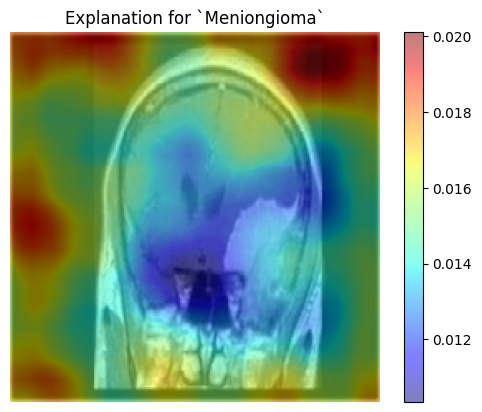

In [ ]:
class_idx = 1
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(img)
plt.imshow(saliency_maps[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

Insertion and Deletion Metrics

Blackbox Model Pass

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models


# Wrap the model with a Softmax layer for output probabilities
A_model = nn.Sequential(A_model, nn.Softmax(dim=1))

# Set the model to evaluation mode
A_model.eval()

# Move the model to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
A_model.to(device)

# Disable gradient computations for the model
for param in A_model.parameters():
    param.requires_grad = False

In [ ]:
###### Importing libraries##########
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torch.nn.functional import conv2d
cudnn.benchmark = True

In [ ]:
from evaluation import CausalMetric, auc, gkern
from utils import *

In [ ]:
n_classes = 4
HW = 224 * 224 # image area

In [ ]:
klen = 11
ksig = 5
kern = gkern(klen, ksig)

# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern, padding=klen//2)

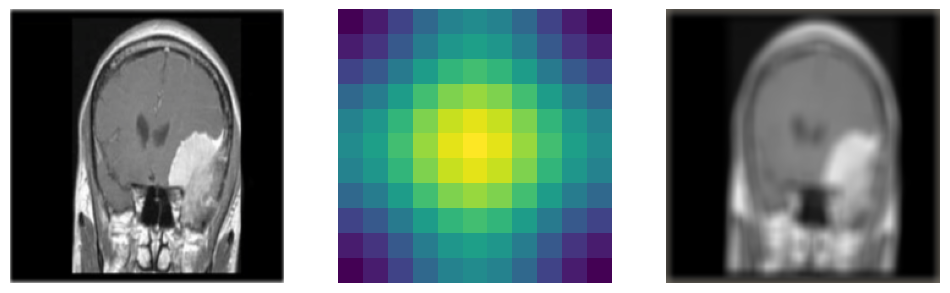

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.axis('off')
img = read_tensor('/content/drive/MyDrive/Colab Notebooks/New-Project/data/meningioma/Te-meTr_0000.jpg')
tensor_imshow(img[0])

plt.subplot(132)
plt.axis('off')
plt.imshow(kern[0, 0])

plt.subplot(133)
plt.axis('off')
tensor_imshow(blur(img)[0])
plt.show()

In [ ]:
class CausalMetric():

    def __init__(self, model, mode, step, substrate_fn):
        r"""Create deletion/insertion metric instance.

        Args:
            model (nn.Module): Black-box model being explained.
            mode (str): 'del' or 'ins'.
            step (int): number of pixels modified per one iteration.
            substrate_fn (func): a mapping from old pixels to new pixels.
        """
        assert mode in ['del', 'ins']
        self.model = model
        self.mode = mode
        self.step = step
        self.substrate_fn = substrate_fn

    def single_run(self, img_tensor, explanation, verbose=0, save_to=None):
        r"""Run metric on one image-saliency pair.

        Args:
            img_tensor (Tensor): normalized image tensor.
            explanation (np.ndarray): saliency map.
            verbose (int): in [0, 1, 2].
                0 - return list of scores.
                1 - also plot final step.
                2 - also plot every step and print 2 top classes.
            save_to (str): directory to save every step plots to.

        Return:
            scores (nd.array): Array containing scores at every step.
        """
        #pred = self.model(img_tensor.cuda())
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # self.model = self.model.to(device)
        # img_tensor = img_tensor.to(device)
        pred = self.model(img_tensor.to(device))

        top, c = torch.max(pred, 1)
        c = c.cpu().numpy()[0]
        n_steps = (HW + self.step - 1) // self.step

        if self.mode == 'del':
            title = 'Deletion game'
            ylabel = 'Pixels deleted'
            start = img_tensor.clone()
            finish = self.substrate_fn(img_tensor)
        elif self.mode == 'ins':
            title = 'Insertion game'
            ylabel = 'Pixels inserted'
            start = self.substrate_fn(img_tensor)
            finish = img_tensor.clone()

        scores = np.empty(n_steps + 1)
        # Coordinates of pixels in order of decreasing saliency

        salient_order = np.flip(np.argsort(explanation.reshape(-1, HW), axis=1), axis=-1)
        for i in range(n_steps+1):
            #start = start.to(device)
            pred = self.model(start.to(device))
            pr, cl = torch.topk(pred, 2)
            # if verbose == 2:
            #     print('{}: {:.3f}'.format(get_class_name(cl[0][0]), float(pr[0][0])))
            #     print('{}: {:.3f}'.format(get_class_name(cl[0][1]), float(pr[0][1])))
            scores[i] = pred[0, c]

            if i < n_steps:
                coords = salient_order[:, self.step * i:self.step * (i + 1)]
                start.cpu().numpy().reshape(1, 3, HW)[0, :, coords] = finish.cpu().numpy().reshape(1, 3, HW)[0, :, coords]



        if verbose == 2 or (verbose == 1 and i == n_steps) or save_to :
                plt.figure(figsize=(10, 5))
                plt.subplot(121)
                plt.title('{} {:.1f}%, P={:.4f}'.format(ylabel, 100 * i / n_steps, scores[i]))
                plt.axis('off')
                tensor_imshow(start[0])

                plt.subplot(122)
                plt.plot(np.arange(i+1) / n_steps, scores[:i+1])
                plt.xlim(-0.1, 1.1)
                plt.ylim(0, 1.05)
                plt.fill_between(np.arange(i+1) / n_steps, 0, scores[:i+1], alpha=0.4)
                plt.title(title,fontsize=16)
                plt.xlabel(ylabel,fontsize=16)
                plt.ylabel(class_name(c),fontsize=16)

                # Increase font size of x and y-axis ticks
                plt.xticks(fontsize=16)  # Adjust fontsize as needed
                plt.yticks(fontsize=16)  # Adjust fontsize as needed

                if save_to:
                    plt.savefig(save_to + '/{:03d}.png'.format(i))
                    plt.close()
                else:
                    plt.show()   # Render image if verbose, if it's the last step or if save is required.

        #print("Final Score:", scores[n_steps])
        print('AUC: {}'.format(auc(scores)))

        return scores

In [ ]:
# Assuming A_model is your model instance
model = A_model
model.eval()  # Set the model to evaluation mode

# Instantiate the CausalMetric class
#causal_metric = CausalMetric(model, mode='ins', step=224, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 224, substrate_fn=torch.zeros_like)

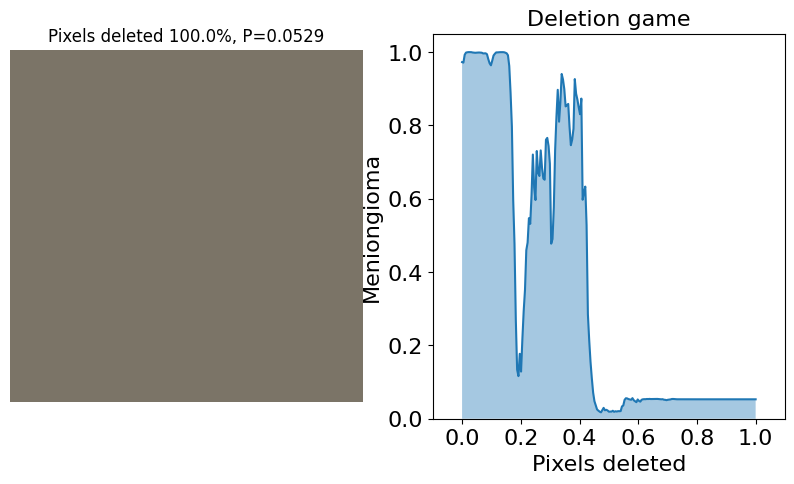

AUC: 0.36348021012132187


In [ ]:
# Run the metric
scores = deletion.single_run(img, saliency_maps, verbose=1)

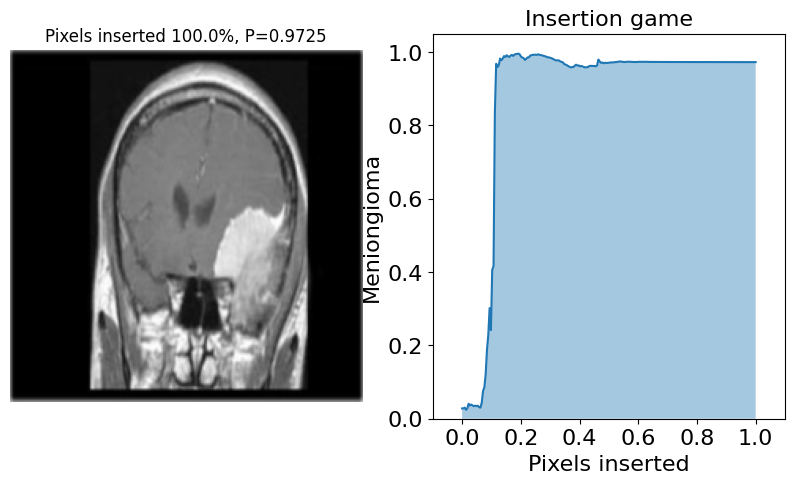

AUC: 0.8788218647948399


In [ ]:
# Assuming A_model is your model instance
model = A_model
#model.eval()  # Set the model to evaluation mode

# Instantiate the CausalMetric class
causal_metric = CausalMetric(model, mode='ins', step=224, substrate_fn=blur)

# Run the metric
scores = causal_metric.single_run(img, saliency_maps, verbose=1)